In [1]:
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import pandas as pd
from string import punctuation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from collections import Counter

In [2]:
from torchmetrics.functional import f1, accuracy

In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv("drive/MyDrive/Fake.csv")

In [5]:
le = LabelEncoder()

In [6]:
df["subject_label"] = le.fit_transform(df["subject"])

In [7]:
df

,title,text,subject,date,subject_label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",2
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",2
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",2
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",2
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",2
...,...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",1
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",1
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",1
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",1


In [8]:
def preprocess_and_tokenize(text):
    tokens = word_tokenize(text)
    clean_tokens = []
    for token in tokens:
        if token not in punctuation:
            clean_tokens.append(token)
    return clean_tokens

In [9]:
lemmatized_text = []
for text in tqdm(df["text"]):
    lemmatized_text.append(preprocess_and_tokenize(text))

  0%|          | 0/23481 [00:00<?, ?it/s]

In [10]:
df["tokenized_text"] = lemmatized_text

In [ ]:
df.to_csv("drive/MyDrive/news_dataframe.csv")

In [ ]:
df = pd.read_csv("drive/MyDrive/news_dataframe.csv")

In [10]:
df.head()

,title,text,subject,date,subject_label,lemmatized_text
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",2,"[Donald, Trump, just, couldn, t, wish, all, Am..."
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",2,"[House, Intelligence, Committee, Chairman, Dev..."
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",2,"[On, Friday, it, was, revealed, that, former, ..."
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",2,"[On, Christmas, day, Donald, Trump, announced,..."
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",2,"[Pope, Francis, used, his, annual, Christmas, ..."


In [11]:
vocab = Counter()
for tokens in df['tokenized_text']:
    vocab.update(list([token.lower() for token in tokens]))
print('всего уникальных токенов:', len(vocab))

всего уникальных токенов: 181078


In [12]:
filtered_vocab = set()

for token in vocab:
    if vocab[token] > 5:
        filtered_vocab.add(token)

In [13]:
token2id = {'PAD':0}

for token in filtered_vocab:
    token2id[token] = len(token2id)

id2token = {i:token for token, i in token2id.items()}

In [14]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [15]:
train_data, val_data = train_test_split(df, test_size=0.2)

In [16]:
class NewsDataset(Dataset):

    def __init__(self, dataset, token2id, DEVICE, pad_len):
        self.dataset = dataset['tokenized_text'].tolist()
        self.token2id = token2id
        self.length = dataset.shape[0]
        self.target = dataset['subject_label'].tolist()
        self.device = DEVICE
        self.pad_len = pad_len

    def __len__(self):
        return self.length

    def collate_fn(self, batch):
        ids, y = list(zip(*batch))
        padded_ids = pad_sequence(ids, batch_first=True).split((self.pad_len),dim=1)[0].to(self.device)
        y = torch.Tensor(y).to(torch.int64).to(self.device)
        return padded_ids, y
    
    def __getitem__(self, index):
        ids = torch.LongTensor([self.token2id[token] for token in tokens if token in self.token2id])    
        y = self.target[index]
        
        return ids, y

In [17]:
train_dataset = NewsDataset(train_data, token2id, DEVICE, 500)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn=train_dataset.collate_fn, sampler=train_sampler, batch_size=64)

In [18]:
val_dataset = NewsDataset(val_data, token2id, DEVICE, 500)
val_sampler = RandomSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn=val_dataset.collate_fn, sampler=val_sampler, batch_size=64)

In [287]:
batch = next(iter(train_iterator))

In [288]:
batch[0].shape

torch.Size([64, 500])

In [289]:
batch[1]

tensor([2, 2, 2, 4, 3, 0, 5, 2, 5, 2, 4, 5, 2, 2, 5, 5, 1, 0, 2, 5, 5, 2, 5, 5,
        0, 5, 5, 4, 0, 2, 4, 2, 2, 5, 2, 4, 2, 3, 4, 2, 0, 2, 5, 2, 4, 0, 5, 3,
        5, 5, 2, 4, 2, 4, 4, 1, 1, 0, 1, 5, 1, 2, 2, 5], device='cuda:0')

In [260]:
[id2token[int(i)] for i in batch[0][0]]

['21st',
 'says',
 'predicted',
 'in',
 'its',
 'new',
 'year',
 's',
 'look',
 'ahead',
 'we',
 'have',
 'a',
 'new',
 'hostage',
 'crisis',
 'military',
 'forces',
 'report',
 'that',
 'two',
 'small',
 'boats',
 'were',
 'seized',
 'in',
 'waters',
 'and',
 'are',
 'currently',
 'being',
 'held',
 'on',
 's',
 'in',
 'the',
 'total',
 'of',
 '10',
 'personnel',
 'nine',
 'men',
 'and',
 'one',
 'woman',
 'have',
 'been',
 'detained',
 'by',
 'authorities',
 'patrol',
 'boat',
 'in',
 'the',
 'to',
 'the',
 'the',
 'initial',
 'narrative',
 'is',
 'as',
 'follows',
 'sailors',
 'were',
 'on',
 'a',
 'training',
 'mission',
 'around',
 'noon',
 'when',
 'their',
 'boat',
 'experienced',
 'mechanical',
 'difficulty',
 'and',
 'drifted',
 'into',
 'waters',
 'and',
 'were',
 'detained',
 'by',
 'the',
 'officials',
 'added',
 'story',
 'has',
 'since',
 'been',
 'slightly',
 'revised',
 'by',
 'spokesman',
 'to',
 'follow',
 'this',
 'narrative',
 '2',
 'boats',
 'were',
 'traveling',
 

In [19]:
class CLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, 100, 2)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=100, hidden_size=256, num_layers=1, batch_first=True)
        self.linear = nn.Linear(256, 6)
        self.softmax = nn.Softmax()
    
    def forward(self, text, prev_state=None):
        embeddings = self.emb(text)
        embeddings = embeddings.transpose(1,2)
        conv = self.conv(embeddings)
        relu = self.relu(conv).transpose(1,2)
        if prev_state:
            output, state = self.lstm(relu, prev_state)
        else:
            output, state = self.lstm(relu)
        logits = self.linear(state[0].squeeze())
        #logits = self.softmax(logits)
        
        return logits

In [21]:
import numpy as np

In [306]:
lm = CLSTM(len(id2token), 300).to(DEVICE)

In [22]:
batch, y = next(iter(train_iterator))
batch, y = batch.to(DEVICE), y.to(DEVICE)
print(batch)

tensor([[23256, 22805,  3837,  ..., 23739,  3119, 11387],
        [23256, 22805,  3837,  ..., 23739,  3119, 11387],
        [23256, 22805,  3837,  ..., 23739,  3119, 11387],
        ...,
        [23256, 22805,  3837,  ..., 23739,  3119, 11387],
        [23256, 22805,  3837,  ..., 23739,  3119, 11387],
        [23256, 22805,  3837,  ..., 23739,  3119, 11387]], device='cuda:0')


In [293]:
y

tensor([5, 0, 2, 0, 2, 5, 2, 2, 3, 5, 4, 1, 2, 5, 2, 4, 4, 5, 2, 4, 2, 2, 2, 2,
        2, 5, 2, 2, 2, 4, 5, 5, 4, 2, 4, 5, 2, 2, 5, 4, 5, 2, 2, 3, 2, 5, 3, 2,
        4, 2, 5, 2, 2, 2, 2, 4, 4, 5, 4, 0, 5, 2, 5, 5], device='cuda:0')

In [23]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(params=lm.parameters())

NameError: ignored

In [ ]:
criterion = criterion.to(DEVICE)

In [28]:
def train(model, iterator, optimizer, criterion):
  epoch_loss = 0
  model.train()


  for i, (texts, ys) in enumerate(tqdm(iterator)):

      texts = texts.to(DEVICE)
      ys = ys.to(DEVICE)
      ys = ys.squeeze()

      optimizer.zero_grad()
      preds = model(texts.to(DEVICE))

      loss = criterion(preds.to(DEVICE), ys.to(DEVICE))
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()

      if not (i + 1) % int(len(iterator)/5):
          print(f'Train loss: {epoch_loss/i}')      
  return  epoch_loss / len(iterator)

In [29]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval()
    with torch.no_grad():
        for i, (texts, ys) in enumerate(tqdm(iterator)):   

            texts = texts.to(DEVICE)
            ys = ys.to(DEVICE)
            ys = ys.squeeze()

            preds = model(texts)
            loss = criterion(preds.to(DEVICE), ys.squeeze()) 
            epoch_loss += loss.item()
            batch_metric = accuracy(preds.argmax(dim=1), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
                print(f'Val loss: {epoch_loss/i}, Val accuracy: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator)

In [311]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(10):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(lm, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(lm, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(lm, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...


  0%|          | 0/294 [00:00<?, ?it/s]

Train loss: 2.26178272774345
Train loss: 1.9422525799792745
Train loss: 1.8080388610762668
Train loss: 1.7560122044055493
Train loss: 1.717161758960737

Evaluating on train...


  0%|          | 0/294 [00:00<?, ?it/s]

Val loss: 1.7407989439211393, Val accuracy: 0.21708375215530396
Val loss: 1.7233211973439093, Val accuracy: 0.20911383628845215
Val loss: 1.7154895556455403, Val accuracy: 0.20553237199783325
Val loss: 1.7092104835427684, Val accuracy: 0.20642325282096863
Val loss: 1.7078756320847772, Val accuracy: 0.20547519624233246

Evaluating on test...


  0%|          | 0/74 [00:00<?, ?it/s]

Val loss: 1.8366600275039673, Val accuracy: 0.22243361175060272
Val loss: 1.776807047702648, Val accuracy: 0.21229569613933563
Val loss: 1.7619773498395594, Val accuracy: 0.20789140462875366
Val loss: 1.7482294581153177, Val accuracy: 0.20317982137203217
Val loss: 1.7473682026932205, Val accuracy: 0.20123416185379028

starting Epoch 1
Training...


  0%|          | 0/294 [00:00<?, ?it/s]

Train loss: 1.6375166512372201
Train loss: 1.593179580439692
Train loss: 1.594447370209446
Train loss: 1.5962557333372371
Train loss: 1.5959480786406046

Evaluating on train...


  0%|          | 0/294 [00:00<?, ?it/s]

Val loss: 1.8251101887016965, Val accuracy: 0.3025447428226471
Val loss: 1.8047972865726636, Val accuracy: 0.3044167459011078
Val loss: 1.7926813405373192, Val accuracy: 0.30863484740257263
Val loss: 1.7847478921279247, Val accuracy: 0.3107001483440399
Val loss: 1.7754478730957401, Val accuracy: 0.3135360777378082

Evaluating on test...


  0%|          | 0/74 [00:00<?, ?it/s]

Val loss: 1.915389189353356, Val accuracy: 0.33167770504951477
Val loss: 1.8619695107142131, Val accuracy: 0.31913501024246216
Val loss: 1.8392359367231044, Val accuracy: 0.31875312328338623
Val loss: 1.8195978381417015, Val accuracy: 0.3142428994178772
Val loss: 1.8145676419354868, Val accuracy: 0.3170478641986847

starting Epoch 2
Training...


  0%|          | 0/294 [00:00<?, ?it/s]

Train loss: 1.6028962344454045
Train loss: 1.5968095893445222
Train loss: 1.6030925546767394
Train loss: 1.5871571003100573
Train loss: 1.5856099730956925

Evaluating on train...


  0%|          | 0/294 [00:00<?, ?it/s]

Val loss: 1.5657929621244733, Val accuracy: 0.41794145107269287
Val loss: 1.5544912877290145, Val accuracy: 0.4144741892814636
Val loss: 1.5460178025196054, Val accuracy: 0.41838380694389343
Val loss: 1.5488505709222902, Val accuracy: 0.41221189498901367
Val loss: 1.5434291540132674, Val accuracy: 0.41450047492980957

Evaluating on test...


  0%|          | 0/74 [00:00<?, ?it/s]

Val loss: 1.6368149702365582, Val accuracy: 0.44435155391693115
Val loss: 1.5974558459387884, Val accuracy: 0.4300697445869446
Val loss: 1.5855651134397926, Val accuracy: 0.42140090465545654
Val loss: 1.5749039975079624, Val accuracy: 0.4244987666606903
Val loss: 1.5767618158589238, Val accuracy: 0.41734153032302856

starting Epoch 3
Training...


  0%|          | 0/294 [00:00<?, ?it/s]

Train loss: 1.6261270088061952
Train loss: 1.600811651478643
Train loss: 1.6006365683726493
Train loss: 1.604583688628622
Train loss: 1.6025612577022565

Evaluating on train...


  0%|          | 0/294 [00:00<?, ?it/s]

Val loss: 1.6376987904833074, Val accuracy: 0.3266206383705139
Val loss: 1.6185231447219848, Val accuracy: 0.3217782974243164
Val loss: 1.620096839921323, Val accuracy: 0.31434157490730286
Val loss: 1.6117031243972448, Val accuracy: 0.31635355949401855
Val loss: 1.6161849288379444, Val accuracy: 0.3143523037433624

Evaluating on test...


  0%|          | 0/74 [00:00<?, ?it/s]

Val loss: 1.73972382912269, Val accuracy: 0.34903186559677124
Val loss: 1.685854434967041, Val accuracy: 0.336398184299469
Val loss: 1.6672833024001703, Val accuracy: 0.3218614161014557
Val loss: 1.6628940278833562, Val accuracy: 0.31358519196510315
Val loss: 1.6528559111166692, Val accuracy: 0.3151702284812927

starting Epoch 4
Training...


  0%|          | 0/294 [00:00<?, ?it/s]

Train loss: 1.607276765923751
Train loss: 1.6194944091465162
Train loss: 1.600872821201479
Train loss: 1.5965742873939084
Train loss: 1.5990204303734856

Evaluating on train...


  0%|          | 0/294 [00:00<?, ?it/s]

Val loss: 1.6827311390324642, Val accuracy: 0.31777286529541016
Val loss: 1.6730828337047412, Val accuracy: 0.3151762783527374
Val loss: 1.6647619346662752, Val accuracy: 0.3173997104167938
Val loss: 1.6634617481396827, Val accuracy: 0.3145722448825836
Val loss: 1.6619375003662902, Val accuracy: 0.3134930729866028

Evaluating on test...


  0%|          | 0/74 [00:00<?, ?it/s]

Val loss: 1.8370925004665668, Val accuracy: 0.3259325623512268
Val loss: 1.7529844928670812, Val accuracy: 0.3160369098186493
Val loss: 1.7283960638976679, Val accuracy: 0.31680089235305786
Val loss: 1.712321797284213, Val accuracy: 0.31606292724609375
Val loss: 1.7069054721058279, Val accuracy: 0.312819242477417

starting Epoch 5
Training...


  0%|          | 0/294 [00:00<?, ?it/s]

Train loss: 1.6017644677245826
Train loss: 1.5962151340816333
Train loss: 1.5905675378148956
Train loss: 1.5882517254197752
Train loss: 1.5862256441149332

Evaluating on train...


  0%|          | 0/294 [00:00<?, ?it/s]

Val loss: 1.8150934545617354, Val accuracy: 0.41907888650894165
Val loss: 1.8136508817258088, Val accuracy: 0.41149935126304626
Val loss: 1.811513481801645, Val accuracy: 0.41165050864219666
Val loss: 1.8081285690332387, Val accuracy: 0.4122268855571747
Val loss: 1.803346450766065, Val accuracy: 0.4145049452781677

Evaluating on test...


  0%|          | 0/74 [00:00<?, ?it/s]

Val loss: 1.9286619333120494, Val accuracy: 0.44100072979927063
Val loss: 1.8837059603797064, Val accuracy: 0.4218587279319763
Val loss: 1.8745818661480416, Val accuracy: 0.4139614403247833
Val loss: 1.8581887743689798, Val accuracy: 0.4116755723953247
Val loss: 1.8322416906771453, Val accuracy: 0.41697484254837036

starting Epoch 6
Training...


  0%|          | 0/294 [00:00<?, ?it/s]

Train loss: 1.6203281189266003
Train loss: 1.6025256478268168
Train loss: 1.6002337147045687
Train loss: 1.6035628256859717
Train loss: 1.5943522119192104

Evaluating on train...


  0%|          | 0/294 [00:00<?, ?it/s]

Val loss: 1.6984624318909227, Val accuracy: 0.4224260449409485
Val loss: 1.6845792656359466, Val accuracy: 0.4183601140975952
Val loss: 1.6827705995195863, Val accuracy: 0.4159703552722931
Val loss: 1.6794288483532993, Val accuracy: 0.4139508306980133
Val loss: 1.6791569918497211, Val accuracy: 0.4149888753890991

Evaluating on test...


  0%|          | 0/74 [00:00<?, ?it/s]

Val loss: 1.7924325649554913, Val accuracy: 0.46743476390838623
Val loss: 1.7392888775578252, Val accuracy: 0.42766353487968445
Val loss: 1.714109595228986, Val accuracy: 0.42401084303855896
Val loss: 1.7035220362923362, Val accuracy: 0.42553961277008057
Val loss: 1.704501734263655, Val accuracy: 0.4193401634693146

starting Epoch 7
Training...


  0%|          | 0/294 [00:00<?, ?it/s]

Train loss: 1.6013354063034058
Train loss: 1.6148855686187744
Train loss: 1.5940825573970816
Train loss: 1.588397318150574
Train loss: 1.5896579513912794

Evaluating on train...


  0%|          | 0/294 [00:00<?, ?it/s]

Val loss: 1.5321798659207528, Val accuracy: 0.4204499423503876
Val loss: 1.511622624811919, Val accuracy: 0.41630852222442627
Val loss: 1.5023156115085403, Val accuracy: 0.41390663385391235
Val loss: 1.5021011839697371, Val accuracy: 0.41461315751075745
Val loss: 1.5002377206478976, Val accuracy: 0.4152539372444153

Evaluating on test...


  0%|          | 0/74 [00:00<?, ?it/s]

Val loss: 1.6161013291432307, Val accuracy: 0.4413023293018341
Val loss: 1.5424383702101532, Val accuracy: 0.44068387150764465
Val loss: 1.544754031227856, Val accuracy: 0.4249795377254486
Val loss: 1.5321265849200163, Val accuracy: 0.41837191581726074
Val loss: 1.5256843636001365, Val accuracy: 0.41989752650260925

starting Epoch 8
Training...


  0%|          | 0/294 [00:00<?, ?it/s]

Train loss: 1.6280823025787086
Train loss: 1.6214190804440043
Train loss: 1.5972750186920166
Train loss: 1.5968641806474495
Train loss: 1.5977795701538402

Evaluating on train...


  0%|          | 0/294 [00:00<?, ?it/s]

Val loss: 1.661647211041367, Val accuracy: 0.3091447651386261
Val loss: 1.6525104543437128, Val accuracy: 0.31205999851226807
Val loss: 1.6477929215899783, Val accuracy: 0.3105737268924713
Val loss: 1.6430459337317067, Val accuracy: 0.3118346333503723
Val loss: 1.639515419732328, Val accuracy: 0.31394147872924805

Evaluating on test...


  0%|          | 0/74 [00:00<?, ?it/s]

Val loss: 1.794145758335407, Val accuracy: 0.3269388973712921
Val loss: 1.7221584143462005, Val accuracy: 0.3185252547264099
Val loss: 1.6792813394127823, Val accuracy: 0.3229573667049408
Val loss: 1.674695179679177, Val accuracy: 0.3155302107334137
Val loss: 1.6748868762582974, Val accuracy: 0.3128277361392975

starting Epoch 9
Training...


  0%|          | 0/294 [00:00<?, ?it/s]

Train loss: 1.642503533446998
Train loss: 1.6078759805015896
Train loss: 1.6074505754977981
Train loss: 1.5993106256831775
Train loss: 1.5908111276098602

Evaluating on train...


  0%|          | 0/294 [00:00<?, ?it/s]

Val loss: 1.7733422726915593, Val accuracy: 0.414150208234787
Val loss: 1.7613088732180389, Val accuracy: 0.41385284066200256
Val loss: 1.762253979037952, Val accuracy: 0.4159799814224243
Val loss: 1.7500969310859582, Val accuracy: 0.41560229659080505
Val loss: 1.7448741354331838, Val accuracy: 0.41446155309677124

Evaluating on test...


  0%|          | 0/74 [00:00<?, ?it/s]

Val loss: 1.922689648774954, Val accuracy: 0.46564874053001404
Val loss: 1.82391212604664, Val accuracy: 0.4390450716018677
Val loss: 1.8093298179347341, Val accuracy: 0.4270722270011902
Val loss: 1.8015554363077337, Val accuracy: 0.41978001594543457
Val loss: 1.7866291999816895, Val accuracy: 0.42037642002105713


In [313]:
acc_eval = f1s_eval

In [314]:
import matplotlib.pyplot as plt

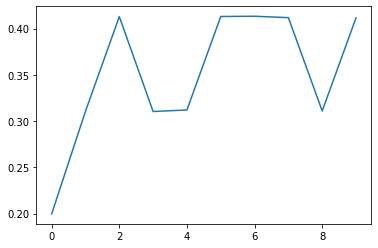

In [315]:
plt.plot(acc_eval)
plt.show()

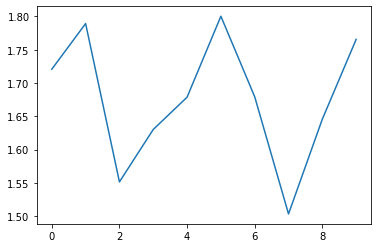

In [316]:
plt.plot(losses_eval)
plt.show()

In [ ]:
with open("/content/drive/MyDrive/wiki-news-300d-1M.vec") as f:
    print(f.read()[:50])

In [67]:
class NewCLSTM(nn.Module):
    def __init__(self,
                 vocab_size,
                 embedding_dim,
                 word2vectorize=None,
                 conv_kernel=2,
                 conv2=False,
                 conv2_kernel=3,
                 dropout_relu=False,
                 dropout_conv=False,
                 conv_output_size=100,
                 lstm_hidden_size=256,
                 lstm_num_layers=1):
        super().__init__()

        if word2vectorize:
          self.emb = nn.Embedding().from_pretrained(word2vectorize)
        else:
          self.emb = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, conv_output_size, conv_kernel)
        self.conv2_bool = conv2
        self.conv2 = nn.Conv1d(embedding_dim, conv_output_size, conv2_kernel)
        if conv2:
            self.lstm_input_size = conv_output_size*2
        else:
            self.lstm_input_size = conv_output_size
        self.relu = nn.ReLU()
        self.dropout_relu = dropout_relu
        self.dropout_conv = dropout_conv
        self.dropout = nn.Dropout(p=0.3)
        self.lstm = nn.LSTM(input_size=self.lstm_input_size,
                            hidden_size=lstm_hidden_size,
                            num_layers=lstm_num_layers,
                            batch_first=True)
        self.linear = nn.Linear(lstm_hidden_size, 6)
    
    def forward(self, text, prev_state=None):
        embeddings = self.emb(text)
        embeddings = embeddings.transpose(1,2)

        conv = self.conv(embeddings)
        if self.dropout_conv:
          conv = self.dropout(conv)
        
        if self.conv2_bool:
          conv2 = self.conv2(embeddings)
          conv_shape = min(conv2.shape[2], conv.shape[2])
          conv = torch.cat([conv.split((conv_shape-1), dim=2)[0], conv2.split((conv_shape-1), dim=2)[0]], dim=1)
        
        relu = self.relu(conv).transpose(1,2)
        if self.dropout_relu:
           relu = self.dropout(relu)

        if prev_state:
            output, state = self.lstm(relu, prev_state)
        else:
            output, state = self.lstm(relu)
        logits = self.linear(state[0].squeeze())
        
        return logits

In [26]:
lm = NewCLSTM(len(id2token),
              300,
              dropout_relu=True,
              dropout_conv=True).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(params=lm.parameters())

In [30]:
losses = []
losses_eval = []
acc = []
acc_eval = []

for i in range(5):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(lm, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    acc_on_train,_ = evaluate(lm, train_iterator, criterion)
    acc.append(acc_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(lm, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    acc_eval.append(f1_on_test)


starting Epoch 0
Training...


  0%|          | 0/294 [00:00<?, ?it/s]

Train loss: 2.128548791534022
Train loss: 1.8381740145061327
Train loss: 1.7403620054267046
Train loss: 1.6809163816047437
Train loss: 1.6544684485168193

Evaluating on train...


  0%|          | 0/294 [00:00<?, ?it/s]

Val loss: 1.6383536949492337, Val accuracy: 0.410441130399704
Val loss: 1.6309224574462227, Val accuracy: 0.4114641845226288
Val loss: 1.6204039092697848, Val accuracy: 0.4125846028327942
Val loss: 1.6140050470054923, Val accuracy: 0.4120161831378937
Val loss: 1.619313746175139, Val accuracy: 0.4121333360671997

Evaluating on test...


  0%|          | 0/74 [00:00<?, ?it/s]

Val loss: 1.7364341020584106, Val accuracy: 0.43768855929374695
Val loss: 1.6556425006301314, Val accuracy: 0.42927056550979614
Val loss: 1.6339488291158908, Val accuracy: 0.4267028570175171
Val loss: 1.6157263539054176, Val accuracy: 0.4269506633281708
Val loss: 1.6089169668114705, Val accuracy: 0.4281998872756958

starting Epoch 1
Training...


  0%|          | 0/294 [00:00<?, ?it/s]

Train loss: 1.5777975111676936
Train loss: 1.5526849798534228
Train loss: 1.5510805087282478
Train loss: 1.5369101767932183
Train loss: 1.535419589095462

Evaluating on train...


  0%|          | 0/294 [00:00<?, ?it/s]

Val loss: 1.68938620466935, Val accuracy: 0.4078093469142914
Val loss: 1.663595341599506, Val accuracy: 0.41029244661331177
Val loss: 1.6611039362890871, Val accuracy: 0.4121343791484833
Val loss: 1.655253943942842, Val accuracy: 0.4125649631023407
Val loss: 1.6526303588312803, Val accuracy: 0.4132941663265228

Evaluating on test...


  0%|          | 0/74 [00:00<?, ?it/s]

Val loss: 1.7661862740149865, Val accuracy: 0.4380466639995575
Val loss: 1.6846831374698215, Val accuracy: 0.43438780307769775
Val loss: 1.672308442069263, Val accuracy: 0.4255407750606537
Val loss: 1.662762282111428, Val accuracy: 0.42735323309898376
Val loss: 1.6460737007251685, Val accuracy: 0.4266851246356964

starting Epoch 2
Training...


  0%|          | 0/294 [00:00<?, ?it/s]

Train loss: 1.5626515338295384
Train loss: 1.5484956057175345
Train loss: 1.5335164883233219
Train loss: 1.5400987765489718
Train loss: 1.5423009659592255

Evaluating on train...


  0%|          | 0/294 [00:00<?, ?it/s]

Val loss: 1.5099486175336336, Val accuracy: 0.4187237024307251
Val loss: 1.4874797748482746, Val accuracy: 0.41319069266319275
Val loss: 1.4813827165978493, Val accuracy: 0.41144847869873047
Val loss: 1.478224685181787, Val accuracy: 0.4133983850479126
Val loss: 1.478734320010281, Val accuracy: 0.4130716025829315

Evaluating on test...


  0%|          | 0/74 [00:00<?, ?it/s]

Val loss: 1.5054907890466542, Val accuracy: 0.4612855613231659
Val loss: 1.4969318928541961, Val accuracy: 0.4341563582420349
Val loss: 1.492124130086201, Val accuracy: 0.4258323609828949
Val loss: 1.4711285764520818, Val accuracy: 0.42925190925598145
Val loss: 1.4668892691100852, Val accuracy: 0.4277135729789734

starting Epoch 3
Training...


  0%|          | 0/294 [00:00<?, ?it/s]

Train loss: 1.573453794445908
Train loss: 1.5699424691822217
Train loss: 1.5580257487434872
Train loss: 1.5529985670403486
Train loss: 1.5457664493046004

Evaluating on train...


  0%|          | 0/294 [00:00<?, ?it/s]

Val loss: 1.5851834656899435, Val accuracy: 0.3067346513271332
Val loss: 1.555920866261358, Val accuracy: 0.308562695980072
Val loss: 1.5480844078725473, Val accuracy: 0.31362295150756836
Val loss: 1.5434720769073025, Val accuracy: 0.31427431106567383
Val loss: 1.5429410893199353, Val accuracy: 0.31388726830482483

Evaluating on test...


  0%|          | 0/74 [00:00<?, ?it/s]

Val loss: 1.6027223330277662, Val accuracy: 0.35292911529541016
Val loss: 1.571316502712391, Val accuracy: 0.32124218344688416
Val loss: 1.542890842367963, Val accuracy: 0.3230702877044678
Val loss: 1.5406010736118663, Val accuracy: 0.31559014320373535
Val loss: 1.539447357689125, Val accuracy: 0.3148111402988434

starting Epoch 4
Training...


  0%|          | 0/294 [00:00<?, ?it/s]

Train loss: 1.5585972007952238
Train loss: 1.5530549070109492
Train loss: 1.5480434791201112
Train loss: 1.5390199071917183
Train loss: 1.5424284823625558

Evaluating on train...


  0%|          | 0/294 [00:00<?, ?it/s]

Val loss: 1.5696420711383485, Val accuracy: 0.31372421979904175
Val loss: 1.5625284485194995, Val accuracy: 0.3093390166759491
Val loss: 1.5545883874672686, Val accuracy: 0.3130267262458801
Val loss: 1.551807850986332, Val accuracy: 0.3130781054496765
Val loss: 1.5476226315778845, Val accuracy: 0.31365126371383667

Evaluating on test...


  0%|          | 0/74 [00:00<?, ?it/s]

Val loss: 1.6321859268041758, Val accuracy: 0.32595759630203247
Val loss: 1.5812577759778057, Val accuracy: 0.3097396790981293
Val loss: 1.5637346680571393, Val accuracy: 0.3132900595664978
Val loss: 1.5519828601316972, Val accuracy: 0.30767911672592163
Val loss: 1.5473273353300232, Val accuracy: 0.31703782081604004


In [32]:
acc_eval

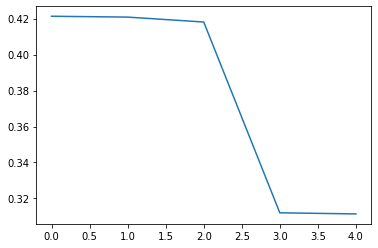

In [35]:
plt.plot(acc_eval)
plt.show()

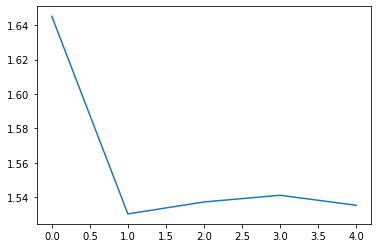

In [36]:
plt.plot(losses)
plt.show()

In [69]:
lm = NewCLSTM(len(id2token),
              300,
              conv2=True,
              conv2_kernel=3,
              dropout_relu=True,
              dropout_conv=True).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(params=lm.parameters(), weight_decay=1e-5)

In [70]:
losses = []
losses_eval = []
acc = []
acc_eval = []

for i in range(5):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(lm, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    acc_on_train,_ = evaluate(lm, train_iterator, criterion)
    acc.append(acc_on_train)
    print('\nEvaluating on test...')
    acc_on_test, epoch_loss_on_test = evaluate(lm, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    acc_eval.append(acc_on_test)


starting Epoch 0
Training...


  0%|          | 0/294 [00:00<?, ?it/s]

Train loss: 2.1177781130138196
Train loss: 1.863955216822417
Train loss: 1.7803396985710012
Train loss: 1.7254606480206245
Train loss: 1.6957733709506924

Evaluating on train...


  0%|          | 0/294 [00:00<?, ?it/s]

Val loss: 1.764077625776592, Val accuracy: 0.41487741470336914
Val loss: 1.7396945839342863, Val accuracy: 0.4084612727165222
Val loss: 1.737164859826854, Val accuracy: 0.4069085121154785
Val loss: 1.7272363586343211, Val accuracy: 0.4105236530303955
Val loss: 1.7222910112988166, Val accuracy: 0.41250109672546387

Evaluating on test...


  0%|          | 0/74 [00:00<?, ?it/s]

Val loss: 1.8847727408775916, Val accuracy: 0.43997979164123535
Val loss: 1.7888049372920283, Val accuracy: 0.42824509739875793
Val loss: 1.7582840308910463, Val accuracy: 0.4284534156322479
Val loss: 1.7318044445731424, Val accuracy: 0.43035975098609924
Val loss: 1.7143087231594583, Val accuracy: 0.42773789167404175

starting Epoch 1
Training...


  0%|          | 0/294 [00:00<?, ?it/s]

Train loss: 1.5618377003753394
Train loss: 1.547310387569925
Train loss: 1.569210755342693
Train loss: 1.5677850473494757
Train loss: 1.5622531270485849

Evaluating on train...


  0%|          | 0/294 [00:00<?, ?it/s]

Val loss: 1.5939562195225765, Val accuracy: 0.3076789379119873
Val loss: 1.5751251013382621, Val accuracy: 0.3075251877307892
Val loss: 1.5656137142567277, Val accuracy: 0.3139142096042633
Val loss: 1.564076701283971, Val accuracy: 0.3141980469226837
Val loss: 1.5611103591621953, Val accuracy: 0.31409546732902527

Evaluating on test...


  0%|          | 0/74 [00:00<?, ?it/s]

Val loss: 1.7084442652188814, Val accuracy: 0.3079855144023895
Val loss: 1.6455473899841309, Val accuracy: 0.3044970631599426
Val loss: 1.5894911754422072, Val accuracy: 0.31836986541748047
Val loss: 1.57605844410983, Val accuracy: 0.3146916627883911
Val loss: 1.5647647035294685, Val accuracy: 0.3169586658477783

starting Epoch 2
Training...


  0%|          | 0/294 [00:00<?, ?it/s]

Train loss: 1.6040340599260832
Train loss: 1.5855171296907509
Train loss: 1.5794682564762976
Train loss: 1.5756469407638947
Train loss: 1.5737256797539734

Evaluating on train...


  0%|          | 0/294 [00:00<?, ?it/s]

Val loss: 1.5222303260836685, Val accuracy: 0.3142772614955902
Val loss: 1.507838597504989, Val accuracy: 0.3111274540424347
Val loss: 1.505570195313823, Val accuracy: 0.31341785192489624
Val loss: 1.5116154486998852, Val accuracy: 0.313169926404953
Val loss: 1.5079334545300493, Val accuracy: 0.31396248936653137

Evaluating on test...


  0%|          | 0/74 [00:00<?, ?it/s]

Val loss: 1.6103325165235078, Val accuracy: 0.3405251204967499
Val loss: 1.544249415397644, Val accuracy: 0.3164079785346985
Val loss: 1.5326885566478823, Val accuracy: 0.31280961632728577
Val loss: 1.5128067471764304, Val accuracy: 0.32160958647727966
Val loss: 1.508418751799542, Val accuracy: 0.3163210451602936

starting Epoch 3
Training...


  0%|          | 0/294 [00:00<?, ?it/s]

Train loss: 1.5455714547843264
Train loss: 1.56900009383326
Train loss: 1.558382074956949
Train loss: 1.5549560485980212
Train loss: 1.5557684642633351

Evaluating on train...


  0%|          | 0/294 [00:00<?, ?it/s]

Val loss: 1.518674605771115, Val accuracy: 0.4195256233215332
Val loss: 1.5011375365049944, Val accuracy: 0.4146750569343567
Val loss: 1.4975612639002718, Val accuracy: 0.41349250078201294
Val loss: 1.4891962597380468, Val accuracy: 0.4128475785255432
Val loss: 1.4831860552197096, Val accuracy: 0.4125189781188965

Evaluating on test...


  0%|          | 0/74 [00:00<?, ?it/s]

Val loss: 1.546657103758592, Val accuracy: 0.47184818983078003
Val loss: 1.5157677906530875, Val accuracy: 0.4437175989151001
Val loss: 1.4946418564494064, Val accuracy: 0.4337133467197418
Val loss: 1.4904815847223456, Val accuracy: 0.4255872666835785
Val loss: 1.480838806732841, Val accuracy: 0.42566370964050293

starting Epoch 4
Training...


  0%|          | 0/294 [00:00<?, ?it/s]

Train loss: 1.5643576132623773
Train loss: 1.5277643473252007
Train loss: 1.5242302410864417
Train loss: 1.5264041939855137
Train loss: 1.5210753081166621

Evaluating on train...


  0%|          | 0/294 [00:00<?, ?it/s]

Val loss: 1.6265241388689007, Val accuracy: 0.42056185007095337
Val loss: 1.62358441663825, Val accuracy: 0.41435620188713074
Val loss: 1.6256885769739315, Val accuracy: 0.41573336720466614
Val loss: 1.627055466433108, Val accuracy: 0.41249552369117737
Val loss: 1.6252263677161458, Val accuracy: 0.41311028599739075

Evaluating on test...


  0%|          | 0/74 [00:00<?, ?it/s]

Val loss: 1.7339078646439772, Val accuracy: 0.4343571066856384
Val loss: 1.6576737032996283, Val accuracy: 0.43183767795562744
Val loss: 1.6370755957394112, Val accuracy: 0.4272408187389374
Val loss: 1.6401786349036478, Val accuracy: 0.420840859413147
Val loss: 1.6267989994823069, Val accuracy: 0.4279068410396576


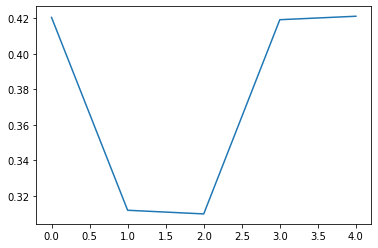

In [71]:
plt.plot(acc_eval)
plt.show()

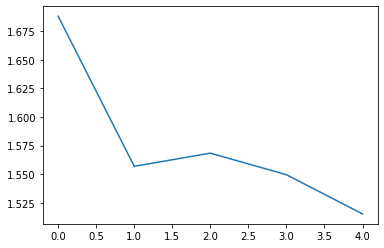

In [72]:
plt.plot(losses)
plt.show()

Как видим, модель работает не очень стабильно и accuracy резко меняется от эпохи к эпохе в изначальной модели. При добавлении дропаута accuracy почему-то сначала растет, а после понижается. Возможно, здесь не помешал бы early stopping. В случае со вторым сверточным слоем, однако, accuracy к концу повышается и стабилизируется на ок. 0.4, в то время как loss падает. Возможно, больше эпох показали бы хорошие результаты.

К сожалению, не хватило времени посмотреть, как влияют другие гиперпараметры :(

In [73]:
# made by nejenek